In [2]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 11.5 MB/s eta 0:00:00


In [11]:
import numpy as np
import pandas as pd  
from matplotlib import pyplot as plt
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLowRankMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam


from scipy.stats import poisson

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dfgames = pd.read_csv('/content/drive/MyDrive/data/games/games.csv')
dfteams = pd.read_csv('/content/drive/MyDrive/data/games/teams.csv')
dfplayers = pd.read_csv('/content/drive/MyDrive/data/games/players.csv')
dfranking = pd.read_csv('/content/drive/MyDrive/data/games/ranking.csv')
dfgamebox = pd.read_csv('/content/drive/MyDrive/data/games/games_details.csv',low_memory=False)
dfplayerpergame = pd.read_csv('/content/drive/MyDrive/data/NBAstats/Player-Per-Game.csv')
dfplayerdata = pd.read_csv('/content/drive/MyDrive/data/player_seasonal/all_seasons.csv')
dfteampergame = pd.read_csv('/content/drive/MyDrive/data/NBAstats/Team-Stats-Per-Game.csv')
dfplayerper36 = pd.read_csv('/content/drive/MyDrive/data/NBAstats/Per-36-Minutes.csv')

dfgames['GAME_DATE_EST'] = pd.to_datetime(dfgames['GAME_DATE_EST'])
dfgames=dfgames.sort_values(by='GAME_DATE_EST',ascending=False)
dfgames=dfgames.drop(range(3102,3131))

In [5]:

dfgames.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

In [6]:
training_games=dfgames[(dfgames["SEASON"] == 2015) |(dfgames["SEASON"] == 2016) |(dfgames["SEASON"] == 2017) |(dfgames["SEASON"] == 2018) | (dfgames["SEASON"] == 2019) | (dfgames["SEASON"] == 2020)]
testing_games=dfgames[(dfgames["SEASON"] == 2021)]

In [ ]:
dfgamebox=dfgamebox.iloc[:-550000]
dfgamebox=dfgamebox.drop(["FG_PCT","FG3_PCT","FT_PCT"],axis=1)

for i in range(len(dfgamebox)):   
    if isinstance(dfgamebox["MIN"].iloc[i],float):
      dfgamebox["MIN"].iloc[i]=0.0
    else:
      temp=dfgamebox["MIN"].iloc[i].split(':');
      dfgamebox["MIN"].iloc[i]=float(temp[0])+float(temp[1])/60.0

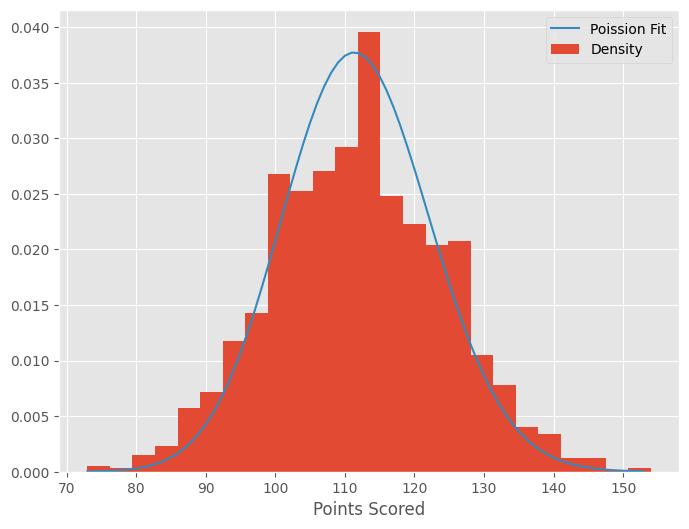

In [51]:
pts=np.concatenate((training_games["PTS_home"].values,training_games["PTS_away"].values))

plt.hist(pts,density=True,bins=25)
x=np.arange(np.min(pts),np.max(pts))
plt.plot(x,poisson.pmf(x,np.mean(pts)))
plt.legend(["Poission Fit","Density",])
plt.xlabel('Points Scored')
plt.show()

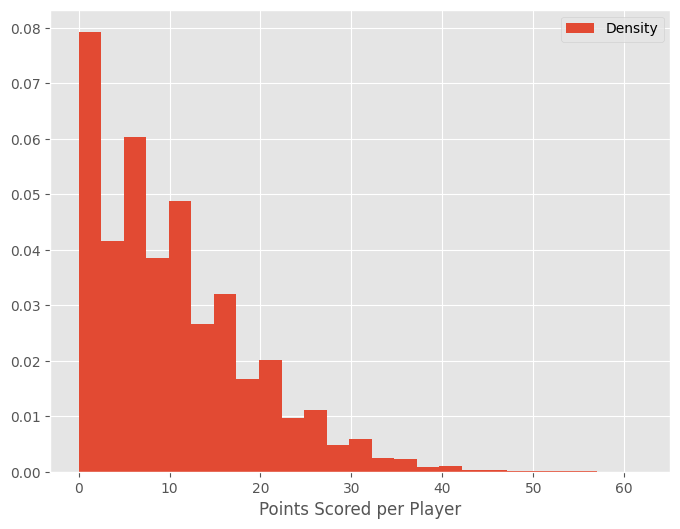

In [49]:
plt.hist(dfgamebox["PTS"],density=True,bins=25)
x=np.arange(np.min(dfgamebox["PTS"]),np.max(dfgamebox["PTS"]))
plt.legend(["Density",])
plt.xlabel('Points Scored per Player')
plt.show()

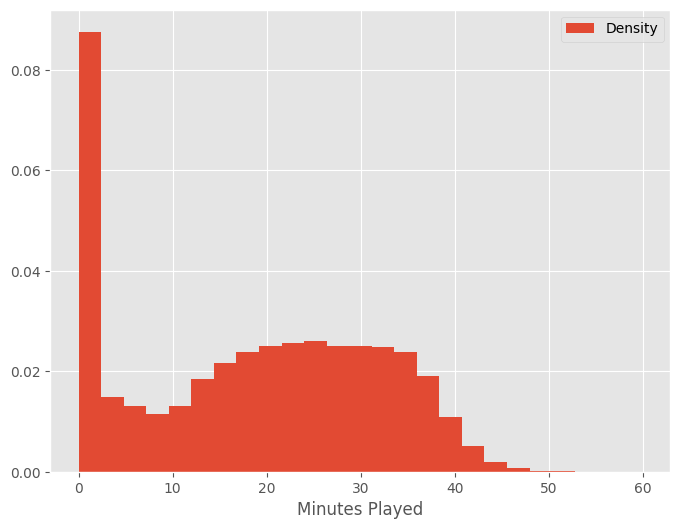

In [50]:
plt.hist(dfgamebox["MIN"],density=True,bins=25)
x=np.arange(np.min(dfgamebox["MIN"]),np.max(dfgamebox["MIN"]))
plt.legend(["Density",])
plt.xlabel('Minutes Played')
plt.show()

In [14]:
x

array([ 64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
        97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
       108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160.])

# Current goal diff

In [ ]:
home_stats=[]
away_stats=[]
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_date=training_games["GAME_DATE_EST"].iloc[i]
         home_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == home_id)	| (dfgames["VISITOR_TEAM_ID"] == home_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10)
         away_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == away_id)	| (dfgames["VISITOR_TEAM_ID"] == away_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10)
         
         idx_home,idx_away=((home_matches["HOME_TEAM_ID"] == home_id).values).astype(int),((away_matches["HOME_TEAM_ID"] == away_id).values).astype(int)
         idx_home[idx_home == 0] = -1
         idx_away[idx_away == 0] = -1

         home_stats.append(( (home_matches["PTS_home"]-home_matches["PTS_away"]) *idx_home).values) 
         away_stats.append(( (away_matches["PTS_home"]-away_matches["PTS_away"]) *idx_away).values) 

home_stats_test=[]
away_stats_test=[]
for i in range(len(testing_games)):
         home_id,away_id=testing_games["HOME_TEAM_ID"].iloc[i],testing_games["VISITOR_TEAM_ID"].iloc[i]
         game_date=testing_games["GAME_DATE_EST"].iloc[i]
         home_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == home_id)	| (dfgames["VISITOR_TEAM_ID"] == home_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10)
         away_matches=dfgames[ ((dfgames["HOME_TEAM_ID"] == away_id)	| (dfgames["VISITOR_TEAM_ID"] == away_id)) & (dfgames["GAME_DATE_EST"]  < game_date)].head(10)
         
         idx_home,idx_away=((home_matches["HOME_TEAM_ID"] == home_id).values).astype(int),((away_matches["HOME_TEAM_ID"] == away_id).values).astype(int)
         idx_home[idx_home == 0] = -1
         idx_away[idx_away == 0] = -1

         home_stats_test.append(( (home_matches["PTS_home"]-home_matches["PTS_away"]) *idx_home).values) 
         away_stats_test.append(( (away_matches["PTS_home"]-away_matches["PTS_away"]) *idx_away).values) 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
home_stats=torch.tensor(home_stats,device=device).float()
away_stats=torch.tensor(away_stats,device=device).float()

home_stats_test=torch.tensor(home_stats_test,device=device).float()
away_stats_test=torch.tensor(away_stats_test,device=device).float()

In [ ]:
X=torch.cat((torch.ones(len(home_stats),1),home_stats,away_stats),dim=1)
X_test=torch.cat((torch.ones(len(home_stats_test),1),home_stats_test,away_stats_test),dim=1)

In [ ]:
y=torch.tensor(training_games["HOME_TEAM_WINS"].values,device=device).float()
y_test=torch.tensor(testing_games["HOME_TEAM_WINS"].values,device=device).float()

In [ ]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        #self.h_layer12 = PyroModule[nn.Linear](n_hidden, n_hidden)
        #self.h_layer12.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_out, n_hidden]).to_event(2))

        self.in_layer2 = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        #self.h_layer22 = PyroModule[nn.Linear](n_hidden, n_hidden)
        #self.h_layer22.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer2 = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X1,X2, y=None):
        X1= self.tanh(self.in_layer(X1))
        X1 = self.tanh(self.h_layer(X1))
        #X1 = self.tanh(self.h_layer12(X1))
        X1 = self.sigmoid(self.out_layer(X1))
        prob1 = X1.squeeze(-1)

        X2= self.tanh(self.in_layer2(X2))
        X2 = self.tanh(self.h_layer2(X2))
        #X2 = self.tanh(self.h_layer22(X2))
        X2 = self.sigmoid(self.out_layer2(X2))
        prob2 = X2.squeeze(-1)

        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Bernoulli(prob1/(prob1+prob2)), obs=y)
            
        return prob1/(prob1+prob2)

In [ ]:
model = FFNN(n_in=home_stats.shape[1], n_hidden=5, n_out=1).to(device)
guide = AutoMultivariateNormal(model)
pyro.clear_param_store()

In [ ]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
initial_lr = 0.01
gamma = 0.01
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})


# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(home_stats,away_stats, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 7084.7
[500] ELBO: 6417.9
[1000] ELBO: 6384.2
[1500] ELBO: 6377.4
[2000] ELBO: 6377.4
[2500] ELBO: 6373.6
[3000] ELBO: 6378.2
[3500] ELBO: 6343.9
[4000] ELBO: 6358.3
[4500] ELBO: 6377.5
[5000] ELBO: 6365.5
[5500] ELBO: 6350.9
[6000] ELBO: 6352.2
[6500] ELBO: 6344.1
[7000] ELBO: 6361.1
[7500] ELBO: 6345.0
[8000] ELBO: 6332.9
[8500] ELBO: 6352.5
[9000] ELBO: 6356.5
[9500] ELBO: 6351.5


In [ ]:


# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(home_stats_test,away_stats_test)

In [ ]:
y_pred=samples["_RETURN"].mean(axis=0)
y_pred

tensor([0.4746, 0.6258, 0.6498, 0.4164, 0.7211, 0.4647, 0.4788, 0.5637, 0.7291,
        0.7321, 0.5814, 0.7256, 0.5116, 0.6728, 0.6800, 0.7235, 0.5373, 0.4976,
        0.5480, 0.6159, 0.4707, 0.5081, 0.4052, 0.6075, 0.4169, 0.7305, 0.6552,
        0.4856, 0.5232, 0.3975, 0.5612, 0.4475, 0.6321, 0.6671, 0.5986, 0.4536,
        0.5228, 0.3904, 0.6950, 0.4117, 0.7148, 0.5512, 0.6182, 0.5535, 0.6431,
        0.6707, 0.5274, 0.5491, 0.4979, 0.3995, 0.4672, 0.5577, 0.7342, 0.6027,
        0.6269, 0.4758, 0.6220, 0.6722, 0.6434, 0.5526, 0.5458, 0.4108, 0.6134,
        0.5607, 0.6614, 0.5235, 0.5071, 0.4677, 0.6187, 0.4567, 0.4431, 0.4460,
        0.5613, 0.4348, 0.6088, 0.5877, 0.7021, 0.6577, 0.6305, 0.5791, 0.4493,
        0.5504, 0.5705, 0.4001, 0.3985, 0.5207, 0.5158, 0.5632, 0.4741, 0.6225,
        0.5511, 0.5537, 0.5135, 0.5865, 0.7039, 0.6902, 0.6396, 0.5702, 0.6344,
        0.4861, 0.4878, 0.4372, 0.4569, 0.5610, 0.5494, 0.6282, 0.4723, 0.5811,
        0.5867, 0.5567, 0.7020, 0.6566, 

In [ ]:
y_pred=samples["_RETURN"].mean(axis=0)

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] =0 

torch.mean((y_pred == y_test).float())

tensor(0.5664)

In [ ]:
# Run inference in Pyro
#nuts_kernel = NUTS(model)
#mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
#mcmc.run(home_stats,away_stats, y)

# Show summary of inference results
#mcmc.summary()

In [ ]:
#predictive = Predictive(model, posterior_samples=mcmc.get_samples(), num_samples=1000,
#                        return_sites=("obs", "_RETURN"))
#samples2 = predictive(home_stats_test,away_stats_test)

In [ ]:
#y_pred=samples2["_RETURN"].mean(axis=0)

#y_pred[y_pred > 0.5] = 1
#y_pred[y_pred <= 0.5] =0 

#torch.mean((y_pred == y_test).float())

# Current team

In [ ]:
dfgames.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

In [ ]:
home_box=[]
away_box=[]
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_date=training_games["GAME_DATE_EST"].iloc[i]
         hh_matches=dfgames[(dfgames["HOME_TEAM_ID"] == home_id) & (dfgames["GAME_DATE_EST"]  < game_date)].head(3)
         ha_matches=dfgames[(dfgames["VISITOR_TEAM_ID"] == home_id) & (dfgames["GAME_DATE_EST"]  < game_date)].head(3)

         ah_matches=dfgames[(dfgames["HOME_TEAM_ID"] == away_id) & (dfgames["GAME_DATE_EST"]  < game_date)].head(3)
         aa_matches=dfgames[(dfgames["VISITOR_TEAM_ID"] == away_id) & (dfgames["GAME_DATE_EST"]  < game_date)].head(3)

         home_offense=0.5*np.mean((hh_matches.iloc[:, 7:12]).values+(ha_matches.iloc[:, 14:19]).values,axis=0) #7:12 14:19
         away_offense=0.5*np.mean((ah_matches.iloc[:, 7:12]).values+(aa_matches.iloc[:, 14:19]).values,axis=0)

         home_defense=0.5*np.mean((hh_matches.iloc[:, 12]).values+(ha_matches.iloc[:, 19]).values,axis=0)
         away_defense=0.5*np.mean((ah_matches.iloc[:, 12]).values+(aa_matches.iloc[:, 19]).values,axis=0)

         home_box.append(np.append(home_offense,home_defense) ) 
         away_box.append(np.append(away_offense,away_defense) ) 


In [ ]:
home_box=torch.tensor(home_box,device=device).float()
away_box=torch.tensor(away_box,device=device).float()

In [ ]:
y1=torch.tensor(training_games["PTS_home"].values,device=device).float()
y2=torch.tensor(training_games["PTS_away"].values,device=device).float()

In [ ]:
def poisson_model(X1,X2, obs1=None,obs2=None):
    alpha1 = pyro.sample("alpha1", pyro.distributions.Normal(0, .1))
    alpha2 = pyro.sample("alpha2", pyro.distributions.Normal(0, .1))
    with pyro.plate("param", X1.shape[1]):
         beta1 = pyro.sample("beta1", pyro.distributions.Normal(0, .1))
         beta2 = pyro.sample("beta2", pyro.distributions.Normal(0, .1))
    with pyro.plate("data", len(X1)):
        pyro.sample("y1", pyro.distributions.Poisson(torch.exp(torch.matmul(X1,beta1)+alpha1)), obs=obs1)
        pyro.sample("y2", pyro.distributions.Poisson(torch.exp(torch.matmul(X2,beta2)+alpha2)), obs=obs2)

In [ ]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class poisson_NN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(poisson_NN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        #self.h_layer12 = PyroModule[nn.Linear](n_hidden, n_hidden)
        #self.h_layer12.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_out, n_hidden]).to_event(2))

        self.in_layer2 = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        #self.h_layer22 = PyroModule[nn.Linear](n_hidden, n_hidden)
        #self.h_layer22.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer2 = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()
        
    def forward(self, X1,X2, obs1=None,obs2=None):
        X1= self.tanh(self.in_layer(X1))
        X1 = self.tanh(self.h_layer(X1))
        #X1 = self.tanh(self.h_layer12(X1))
        X1 = (self.out_layer(X1))
        prob1 = X1.squeeze(-1)

        X2= self.tanh(self.in_layer2(X2))
        X2 = self.tanh(self.h_layer2(X2))
        #X2 = self.tanh(self.h_layer22(X2))
        X2 = self.out_layer2(X2)
        prob2 = X2.squeeze(-1)

        with pyro.plate("observations"):
            pyro.sample("y1", pyro.distributions.Poisson(torch.exp(prob1)), obs=obs1)
            pyro.sample("y2", pyro.distributions.Poisson(torch.exp(prob2)), obs=obs2)

In [ ]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class poisson_NN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(poisson_NN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        #self.h_layer12 = PyroModule[nn.Linear](n_hidden, n_hidden)
        #self.h_layer12.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_out, n_hidden]).to_event(2))

        self.in_layer2 = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        #self.h_layer22 = PyroModule[nn.Linear](n_hidden, n_hidden)
        #self.h_layer22.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer2 = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer2.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X1,X2, obs=None):
        X1= self.tanh(self.in_layer(X1))
        X1 = self.tanh(self.h_layer(X1))
        #X1 = self.tanh(self.h_layer12(X1))
        X1 = self.sigmoid((self.out_layer(X1)))
        prob1 = X1.squeeze(-1)

        X2= self.tanh(self.in_layer2(X2))
        X2 = self.tanh(self.h_layer2(X2))
        #X2 = self.tanh(self.h_layer22(X2))
        X2 = self.sigmoid(self.out_layer2(X2))
        prob2 = X2.squeeze(-1)

        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Bernoulli(prob1/(prob1+prob2)), obs=obs)
        return prob1/(prob1+prob2)

In [ ]:
def log_regress(X, obs=None):
    with pyro.plate("param", X.shape[1]):
         alpha=pyro.sample("alpha", pyro.distributions.Beta(10,10))
         beta = pyro.sample("beta", pyro.distributions.Normal(0, 1.0/alpha))
    with pyro.plate("data", len(X)):
        y=pyro.sample("y", pyro.distributions.Bernoulli(torch.sigmoid(torch.matmul(X,beta))), obs=obs)
    return y

In [ ]:
X=torch.cat((torch.ones((len(home_box),1)),home_box,away_box),dim=1)

In [ ]:
# Define guide function
#model_NN=poisson_NN(n_in=home_box.shape[1], n_hidden=5, n_out=1).to(device)
guide =AutoMultivariateNormal(log_regress)

# Reset parameter values
pyro.clear_param_store()

In [ ]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
initial_lr = 0.01
gamma = 0.01
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(log_regress, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 50612.6
[500] ELBO: 5793.7
[1000] ELBO: 5342.8
[1500] ELBO: 5322.9
[2000] ELBO: 5323.5
[2500] ELBO: 5313.3
[3000] ELBO: 5316.4
[3500] ELBO: 5311.9
[4000] ELBO: 5309.9
[4500] ELBO: 5301.4
[5000] ELBO: 5309.4
[5500] ELBO: 5302.1
[6000] ELBO: 5309.6
[6500] ELBO: 5304.1
[7000] ELBO: 5305.2
[7500] ELBO: 5305.7
[8000] ELBO: 5302.4
[8500] ELBO: 5301.4
[9000] ELBO: 5302.7
[9500] ELBO: 5303.3


In [ ]:

predictive = Predictive(log_regress, guide=guide, num_samples=1000,
                        return_sites=("beta","y","_RETURN"))
samples = predictive(X_test)

In [ ]:
y_pred=samples["y"].mean(axis=0)

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] =0 

torch.mean((y_pred == y_test).float())

tensor(0.6170)

In [ ]:
y_pred

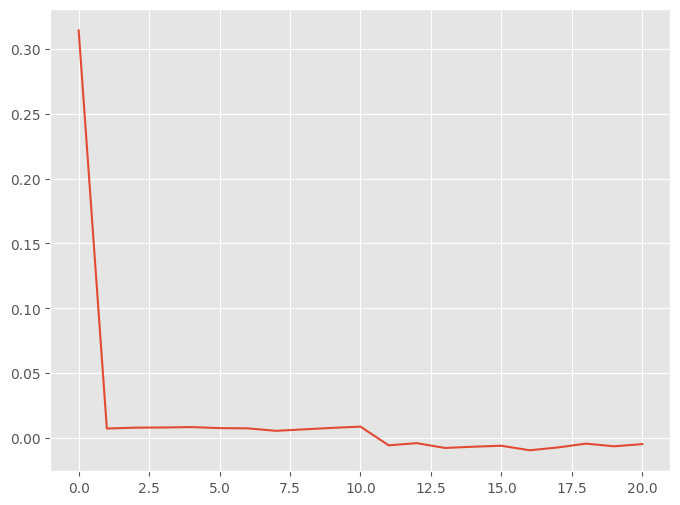

In [ ]:
plt.plot(samples["beta"].mean(axis=0))

# Last season team averages...

In [ ]:
dfteampergame.columns

Index(['season', 'lg', 'team', 'abbreviation', 'playoffs', 'g', 'mp_per_game',
       'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game',
       'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game',
       'x2p_percent', 'ft_per_game', 'fta_per_game', 'ft_percent',
       'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game',
       'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game',
       'pts_per_game'],
      dtype='object')

In [ ]:
dfteampergame.iloc[0]

season                    2023
lg                         NBA
team             Atlanta Hawks
abbreviation               ATL
playoffs                 False
g                         62.0
mp_per_game              242.0
fg_per_game               44.2
fga_per_game              92.1
fg_percent               0.479
x3p_per_game              10.7
x3pa_per_game             30.4
x3p_percent              0.353
x2p_per_game              33.4
x2pa_per_game             61.7
x2p_percent              0.542
ft_per_game               17.8
fta_per_game              21.8
ft_percent               0.819
orb_per_game              10.6
drb_per_game              33.2
trb_per_game              43.9
ast_per_game              24.6
stl_per_game               6.9
blk_per_game               5.0
tov_per_game              12.7
pf_per_game               19.0
pts_per_game             116.9
Name: 0, dtype: object

In [ ]:
dfteampergame=dfteampergame.replace(to_replace="CHA",value="CHO")
dfteams=dfteams.replace(to_replace=["BKN","CHA","PHX"],value=["BRK","CHO","PHO"])

In [ ]:
dfteampergame=dfteampergame.loc[dfteampergame["team"] != "League Average",:]
dfteampergame=dfteampergame.replace(to_replace=dfteams["ABBREVIATION"].tolist(),value=dfteams["TEAM_ID"].tolist())
dfteampergame=dfteampergame.rename(columns={"abbreviation": "TEAM_ID"})

In [ ]:
training_ta=dfteampergame[(dfteampergame["season"] == 2014) | (dfteampergame["season"] == 2015) | (dfteampergame["season"] == 2016) | (dfteampergame["season"] == 2017) |(dfteampergame["season"] == 2018) | (dfteampergame["season"] == 2019) | (dfteampergame["season"] == 2020) ]
testing_ta=dfteampergame[(dfteampergame["season"] == 2021)]

In [ ]:
home_ls=[]
away_ls=[]
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         season=training_games["SEASON"].iloc[i]

         home_ls.append(dfteampergame[(dfteampergame["TEAM_ID"] == home_id) & (dfteampergame["season"] == season-1)].iloc[:,].values)
         away_ls.append(dfteampergame[(dfteampergame["TEAM_ID"] == away_id) & (dfteampergame["season"] == season-1)].iloc[:,7:].values)



In [ ]:
home_ls=torch.squeeze(torch.tensor(home_ls,device=device).float())
away_ls=torch.squeeze(torch.tensor(away_ls,device=device).float())

In [ ]:
home_team=torch.cat((home_box,home_ls),dim=1)
away_team=torch.cat((home_box,home_ls),dim=1)

In [ ]:
X=torch.cat((torch.ones((len(home_box),1)),home_ls,away_ls),dim=1)

In [ ]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
class NN_all(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(NN_all, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.h_layer12 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer12.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.h_layer13 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer13.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., torch.tensor(2.0,device=device)).expand([n_out, n_hidden]).to_event(2))


        # Activation functions
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X1,X2, obs=None):
        X1= self.tanh(self.in_layer(X1))
        X1 = self.tanh(self.h_layer(X1))
        X1 = self.tanh(self.h_layer12(X1))
        X1 = self.tanh(self.h_layer13(X1))
        X1 = self.sigmoid((self.out_layer(X1)))
        prob1 = X1.squeeze(-1)

        X2= self.tanh(self.in_layer(X2))
        X2 = self.tanh(self.h_layer(X2))
        X2 = self.tanh(self.h_layer12(X2))
        X2 = self.tanh(self.h_layer13(X2))
        X2 = self.sigmoid((self.out_layer(X2)))
        prob2 = X2.squeeze(-1)


        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Bernoulli(logits=torch.log(prob1)-torch.log(prob1+prob2)), obs=obs)
        return prob1/(prob1+prob2)

In [ ]:
model_NN=NN_all(n_in=home_team.shape[1], n_hidden=50, n_out=1).to(device)
guide =AutoDiagonalNormal(model_NN).to(device)

# Reset parameter values
pyro.clear_param_store()

In [ ]:
n_steps = 20000

# Setup the optimizer
initial_lr = 0.01
gamma = 0.001
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model_NN, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(home_team,away_team,y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 30187.4
[500] ELBO: 8226.0
[1000] ELBO: 7567.1
[1500] ELBO: 7560.3
[2000] ELBO: 7557.5
[2500] ELBO: 7560.9
[3000] ELBO: 7554.2
[3500] ELBO: 7555.0
[4000] ELBO: 7549.9
[4500] ELBO: 7551.6
[5000] ELBO: 7543.3
[5500] ELBO: 7551.8
[6000] ELBO: 7547.8
[6500] ELBO: 7547.7
[7000] ELBO: 7551.0
[7500] ELBO: 7551.7
[8000] ELBO: 7547.1
[8500] ELBO: 7547.2
[9000] ELBO: 7547.2
[9500] ELBO: 7545.5
[10000] ELBO: 7545.5
[10500] ELBO: 7546.1
[11000] ELBO: 7545.7
[11500] ELBO: 7546.8
[12000] ELBO: 7548.0
[12500] ELBO: 7547.2
[13000] ELBO: 7546.3
[13500] ELBO: 7548.6
[14000] ELBO: 7544.1
[14500] ELBO: 7547.2
[15000] ELBO: 7545.2
[15500] ELBO: 7545.6
[16000] ELBO: 7546.7
[16500] ELBO: 7545.9
[17000] ELBO: 7547.9
[17500] ELBO: 7546.4
[18000] ELBO: 7547.7
[18500] ELBO: 7549.0
[19000] ELBO: 7545.1
[19500] ELBO: 7546.0


In [ ]:
predictive = Predictive(model_NN, guide=guide, num_samples=1000,
                        return_sites=("obs","_RETURN"))
samples = predictive(home_team,away_team)

In [ ]:
y_pred=samples["_RETURN"].mean(axis=0)

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] =0 

torch.mean((y_pred == y).float())

tensor(0.4306, device='cuda:0')

# Last season player stats...

In [ ]:
dfgamebox.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS',
       'PLUS_MINUS'],
      dtype='object')

In [ ]:
dfgamebox=dfgamebox.replace(to_replace=["Enes Freedom","Jeff Dowtin"],value=["Jeff Dowtin Jr.","Enes Kanter"])

In [ ]:
dfplayerper36=dfplayerper36.replace(to_replace=["Robert Williams","Kevin Knox","OG Anunoby","Marcus Morris","Xavier Tillman Sr.","Jeff Dowtin","Melvin Frazier","Derrick Walton","C.J. Miles","B.J. Johnson","PJ Dozier","Enes Freedom","Harry Giles","Nicolas Claxton","J.J. Redick","Brian Bowen","Frank Mason III","Luka Dončić","Dāvis Bertāns","Boban Marjanović","Jonas Valančiūnas","Willy Hernangómez","Bojan Bogdanović","Juancho Hernangómez","Goran Dragić","Nikola Vučević","Nikola Jokić","Vlatko Čančar","Bogdan Bogdanović","Timothé Luwawu-Cabarrot","Alperen Şengün","Tomáš Satoranský","O.G. Anunoby","P.J. Dozier"],value=["Robert Williams III","Kevin Knox II","O.G. Anunoby","Marcus Morris Sr.","Xavier Tillman","Jeff Dowtin Jr.","Melvin Frazier Jr.","Derrick Walton Jr.","CJ Miles","BJ Johnson","P.J. Dozier","Enes Kanter","Harry Giles III","Nic Claxton","JJ Redick","Brian Bowen II","Frank Mason","Luka Doncic","Davis Bertans","Boban Marjanovic","Jonas Valanciunas","Willy Hernangomez","Bojan Bogdanovic","Juancho Hernangomez","Goran Dragic","Nikola Vucevic","Nikola Jokic","Vlatko Cancar","Bogdan Bogdanovic","Timothe Luwawu-Cabarrot","Alperen Sengun","Tomas Satoransky","O.G. Anunoby","PJ Dozier"])

In [ ]:
pip install Unidecode

In [ ]:
import unidecode
for i in range(len(dfplayerper36)):
  dfplayerper36["player"].iloc[i]=unidecode.unidecode(dfplayerper36["player"].iloc[i])
  #dfplayerper36["player"].iloc[i] = dfplayerper36["player"].iloc[i].replace('.','',-1)

In [ ]:
dfplayerper36_fix=dfplayerper36[dfplayerper36["mp"] >= 72]

In [ ]:
home_players=[]
away_players=[]
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_id=training_games["GAME_ID"].iloc[i]
         season=training_games["SEASON"].iloc[i]

         game_home=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==home_id)]
         game_away=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==away_id)]

         temp_home=[]
         temp_away=[]
         for j in range(10):
            player=game_home["PLAYER_NAME"].iloc[j]
            if np.sum((dfplayerper36_fix["player"] == player) & (dfplayerper36_fix["season"] == season-1)) >= 1:
              temp_home.append((dfplayerper36_fix[(dfplayerper36_fix["player"] == player) & (dfplayerper36_fix["season"] == season-1)].iloc[-1,13:]).values.ravel().astype('float32'))
            else: 
              temp_home.append(np.nanmean(dfplayerper36_fix[dfplayerper36_fix["season"]==season].iloc[:,13:].values,axis=0))

         home_players.append(temp_home)

         for j in range(10):
            player=game_away["PLAYER_NAME"].iloc[j]
            if np.sum((dfplayerper36_fix["player"] == player) & (dfplayerper36_fix["season"] == season-1)) >= 1:
              temp_home.append((dfplayerper36_fix[(dfplayerper36_fix["player"] == player) & (dfplayerper36_fix["season"] == season-1)].iloc[-1,13:]).values.ravel().astype('float32'))
            else: 
              temp_home.append(np.nanmean(dfplayerper36_fix[dfplayerper36_fix["season"]==season].iloc[:,13:].values,axis=0))

         away_players.append(temp_home)

In [ ]:
x=torch.tensor(home_players).float()

In [ ]:
x

# Players Current form

In [24]:
training_games=dfgames[(dfgames["SEASON"] == 2020)]
testing_games=dfgames[(dfgames["SEASON"] == 2021)]

In [25]:
dfgamebox = pd.read_csv('/content/drive/MyDrive/data/games/games_details.csv',low_memory=False)
dfgamebox=dfgamebox.iloc[:-550000]
dfgamebox=dfgamebox.drop(["FG_PCT","FG3_PCT","FT_PCT"],axis=1)


In [26]:
dfgamebox.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM',
       'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS'],
      dtype='object')

In [ ]:
dfgamebox = pd.read_csv('/content/drive/MyDrive/data/games/games_details.csv',low_memory=False)
dfgamebox=dfgamebox.iloc[:-550000]
dfgamebox=dfgamebox.drop(["FG_PCT","FG3_PCT","FT_PCT"],axis=1)

for i in range(len(dfgamebox)):   
    if isinstance(dfgamebox["MIN"].iloc[i],float):
      dfgamebox["MIN"].iloc[i]=0.0
    else:
      temp=dfgamebox["MIN"].iloc[i].split(':');
      dfgamebox["MIN"].iloc[i]=float(temp[0])+float(temp[1])/60.0

In [ ]:
for i in range(len(dfgamebox)):   
    dfgamebox["TEAM_CITY"].iloc[i]=dfgames["GAME_DATE_EST"][dfgames["GAME_ID"] == dfgamebox["GAME_ID"].iloc[i]].item()
    

<ipython-input-10-a5af21a55298>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgamebox["TEAM_CITY"].iloc[i]=dfgames["GAME_DATE_EST"][dfgames["GAME_ID"] == dfgamebox["GAME_ID"].iloc[i]].item()


In [ ]:
dfgamebox=dfgamebox.rename(columns={"TEAM_CITY": "DATE"})
dfgamebox=dfgamebox.sort_values(by='DATE',ascending=False)

In [ ]:
dfgamebox_fix=dfgamebox[dfgamebox["MIN"] >= 10]

In [ ]:
mean=np.mean(dfgamebox_fix.iloc[:,10:].values/dfgamebox_fix.iloc[:,9].values[:,None],axis=0).astype('float')

In [ ]:
home_cur=[]
away_cur=[]
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_id=training_games["GAME_ID"].iloc[i]
         season=training_games["SEASON"].iloc[i]
         game_date=training_games["GAME_DATE_EST"].iloc[i]

         game_home=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==home_id)]
         game_away=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==away_id)]

         temp_home=[]
         temp_away=[]
         for j in range(10):
            player=game_home["PLAYER_NAME"].iloc[j]
            if np.sum( (dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d') )) >= 3:
              temp=dfgamebox_fix[(dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(5)
              temp_home.append(np.mean(temp.iloc[:,10:].values/temp.iloc[:,9].values[:,None],axis=0).astype('float'))
            else:
              temp_home.append(mean)

         home_cur.append(temp_home)

         for j in range(10):
            player=game_away["PLAYER_NAME"].iloc[j]
            if np.sum( (dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d') )) >= 3:
              temp=dfgamebox_fix[(dfgamebox_fix["PLAYER_NAME"] == player) & (dfgamebox_fix["DATE"] < game_date) &  (dfgamebox_fix["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(5)
              temp_away.append(np.mean(temp.iloc[:,10:].values/temp.iloc[:,9].values[:,None],axis=0).astype('float'))
            else:
              temp_away.append(mean)

         away_cur.append(temp_away)

In [ ]:
home_time=[]
away_time=[]

home_y_time=[]
away_y_time=[]
for i in range(len(training_games)):
         home_id,away_id=training_games["HOME_TEAM_ID"].iloc[i],training_games["VISITOR_TEAM_ID"].iloc[i]
         game_id=training_games["GAME_ID"].iloc[i]
         season=training_games["SEASON"].iloc[i]
         game_date=training_games["GAME_DATE_EST"].iloc[i]

         game_home=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==home_id)]
         game_away=dfgamebox[(dfgamebox["GAME_ID"]== game_id) & (dfgamebox["TEAM_ID"]==away_id)]

         home_y_time.append(game_home["MIN"].iloc[:10].values.astype('float'))
         away_y_time.append(game_away["MIN"].iloc[:10].values.astype('float'))
         temp_home=[]
         temp_away=[]
         for j in range(10):
            player=game_home["PLAYER_NAME"].iloc[j]
            temp=dfgamebox[(dfgamebox["PLAYER_NAME"] == player) & (dfgamebox["DATE"] < game_date) &  (dfgamebox["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(3) 
            if len(temp) < 3:
              temp_home.append(np.concatenate((temp["MIN"].values,np.zeros(3-len(temp))) ).astype('float') )
            else:
              temp_home.append(temp["MIN"].values.astype('float'))

         home_time.append(temp_home)

         for j in range(10):
            player=game_away["PLAYER_NAME"].iloc[j]
            temp=dfgamebox[(dfgamebox["PLAYER_NAME"] == player) & (dfgamebox["DATE"] < game_date) &  (dfgamebox["DATE"] > game_date-pd.to_timedelta(365,unit='d'))].head(3)
            if len(temp) < 3:
              temp_away.append(np.concatenate((temp["MIN"].values,np.zeros(3-len(temp))) ).astype('float') )
            else:
              temp_away.append(temp["MIN"].values.astype('float'))

         away_time.append(temp_away)

In [ ]:
home_time=torch.tensor(home_time).float()
away_time=torch.tensor(away_time).float()

home_y_time=torch.tensor(home_y_time).float()
away_y_time=torch.tensor(away_y_time).float()

In [ ]:
def time_model(X1,X2,obs1=None,obs2=None):
      with pyro.plate("param2", X1.shape[2]):
            beta = pyro.sample("beta", pyro.distributions.Normal(0, 1.0))

      print(torch.exp(torch.matmul(X1,beta)))
      with pyro.plate("obs", len(X1)):
        y1=pyro.sample("y1", pyro.distributions.Dirichlet(torch.exp(torch.matmul(X1,beta))), obs=obs1)
        y2=pyro.sample("y2", pyro.distributions.Dirichlet(torch.exp(torch.matmul(X2,beta))), obs=obs2)

      return y1

In [ ]:
guide =AutoDiagonalNormal(time_model)

# Reset parameter values
pyro.clear_param_store()

In [ ]:
n_steps = 20000

# Setup the optimizer
initial_lr = 0.01
gamma = 0.001
lrd = gamma ** (1 / n_steps)
optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(time_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(home_time,away_time,home_y_time,away_y_time)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

tensor([[2.3420e-03, 3.8264e-01, 1.2668e-04,  ..., 3.1228e-05, 1.0000e+00,
         9.8516e-02],
        [7.4406e-01, 2.3264e-05, 1.3046e-05,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [2.2733e+00, 3.9486e-06, 5.1957e-05,  ..., 9.3405e-01, 1.0000e+00,
         3.5121e-03],
        ...,
        [1.0000e+00, 1.5943e-04, 2.4768e-04,  ..., 1.6089e-04, 3.5274e-02,
         5.1401e-03],
        [1.0000e+00, 1.8742e-02, 9.2572e-02,  ..., 5.2552e-02, 5.4446e+01,
         1.0030e-03],
        [9.3666e-07, 1.7553e-04, 2.1385e+00,  ..., 3.9243e+00, 8.1945e-06,
         1.0000e+00]])
tensor([[1.8531e-03, 2.5009e+00, 1.6693e-03,  ..., 6.5661e-05, 1.0000e+00,
         5.7082e-02],
        [7.9853e-01, 4.5671e-05, 3.6501e-05,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [2.7634e+00, 1.9026e-05, 3.7520e-04,  ..., 9.4941e-01, 1.0000e+00,
         1.7159e-03],
        ...,
        [1.0000e+00, 3.1049e-04, 4.1314e-04,  ..., 9.5263e-04, 9.7735e-02,
         2.3050e-02],
   

/usr/local/lib/python3.10/dist-packages/pyro/poutine/trace_struct.py:246: UserWarning: Encountered NaN: log_prob_sum at site 'y1'
  warn_if_nan(
/usr/local/lib/python3.10/dist-packages/pyro/poutine/trace_struct.py:246: UserWarning: Encountered NaN: log_prob_sum at site 'y2'
  warn_if_nan(
/usr/local/lib/python3.10/dist-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


ValueError: ignored